In [6]:
!rm -rf /kaggle/working/*

In [7]:
import os
import cv2

def extract_frames(video_path, output_dir, label):
    os.makedirs(output_dir, exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    count = 0
    frame_id = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if count % fps == 0:  # One frame per second
            save_path = os.path.join(output_dir, f"{label}_{os.path.basename(video_path).split('.')[0]}_{frame_id}.jpg")
            cv2.imwrite(save_path, frame)
            frame_id += 1
        count += 1
    cap.release()

In [8]:
real_dir = "/kaggle/input/celeb-df-v2/Celeb-real"
fake_dir = "/kaggle/input/celeb-df-v2/Celeb-synthesis"
yt_dir = "/kaggle/input/celeb-df-v2/YouTube-real"
output_real = "/kaggle/working/frames/real"
output_fake = "/kaggle/working/frames/fake"

for video in os.listdir(real_dir):
    extract_frames(os.path.join(real_dir, video), output_real, "real")

for video in os.listdir(fake_dir):
    extract_frames(os.path.join(fake_dir, video), output_fake, "fake")

In [22]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import glob

# Paths
real_imgs = glob.glob("/kaggle/working/frames/real/*.jpg")
fake_imgs = glob.glob("/kaggle/working/frames/fake/*.jpg")
file_paths = real_imgs + fake_imgs
labels = [0]*len(real_imgs) + [1]*len(fake_imgs)

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(file_paths, labels, test_size=0.3, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp)


In [23]:
IMG_SIZE = (299, 299)

def load_preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.keras.applications.xception.preprocess_input(img)
    return img, label

def get_dataset(paths, labels, batch_size=32, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(len(paths))
    ds = ds.map(load_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_ds = get_dataset(X_train, y_train)
val_ds = get_dataset(X_val, y_val, shuffle=False)
test_ds = get_dataset(X_test, y_test, shuffle=False)

In [24]:
from sklearn.metrics import roc_curve
import numpy as np

def compute_eer(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    fnr = 1 - tpr
    eer_threshold_idx = np.nanargmin(np.abs(fnr - fpr))
    eer = (fpr[eer_threshold_idx] + fnr[eer_threshold_idx]) / 2
    return eer

In [32]:
class EERCallback(Callback):
    def __init__(self, val_dataset):
        super(EERCallback, self).__init__()
        self.val_dataset = val_dataset

    def on_epoch_end(self, epoch, logs=None):
        y_true = []
        y_pred = []
        for batch in self.val_dataset:
            images, labels = batch
            preds = self.model.predict(images, verbose=0).ravel()
            y_pred.extend(preds)
            y_true.extend(labels.numpy())
        
        eer = self.compute_eer(np.array(y_true), np.array(y_pred))
        print(f'\nEpoch {epoch+1} — Equal Error Rate (EER): {eer:.4f}')

    def compute_eer(self, y_true, y_score):
        fpr, tpr, _ = roc_curve(y_true, y_score)
        fnr = 1 - tpr
        eer_threshold_idx = np.nanargmin(np.abs(fnr - fpr))
        eer = (fpr[eer_threshold_idx] + fnr[eer_threshold_idx]) / 2
        return eer

In [33]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model

base = Xception(include_top=False, weights='imagenet', input_shape=(299, 299, 3))
base.trainable = False  # Freeze base initially

x = GlobalAveragePooling2D()(base.output)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

eer_callback = EERCallback(val_dataset=val_ds)

model = Model(inputs=base.input, outputs=output)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 299, 299, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 149, 149, 32)   │            864 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 149, 149, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 149, 149, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 147, 147, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 147, 147, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 147, 147, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 147, 147, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 147, 147, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 147, 147, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_28 (Conv2D)        │ (None, 74, 74, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 74, 74, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 20,863,529 (79.59 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [35]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    eer_callback
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks
)

print(f"Finished Execution!")

Epoch 1/20
1780/1781 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9051 - auc: 0.6156 - loss: 0.3090 - precision: 0.9053 - recall: 0.9996
Epoch 1 — Equal Error Rate (EER): 0.4076
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 328s 184ms/step - accuracy: 0.9051 - auc: 0.6155 - loss: 0.3090 - precision: 0.9053 - recall: 0.9995 - val_accuracy: 0.9039 - val_auc: 0.6235 - val_loss: 0.3118 - val_precision: 0.9039 - val_recall: 1.0000
Epoch 2/20
1780/1781 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9018 - auc: 0.6197 - loss: 0.3147 - precision: 0.9023 - recall: 0.9994
Epoch 2 — Equal Error Rate (EER): 0.3972
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 329s 184ms/step - accuracy: 0.9018 - auc: 0.6197 - loss: 0.3147 - precision: 0.9023 - recall: 0.9994 - val_accuracy: 0.9042 - val_auc: 0.6422 - val_loss: 0.3030 - val_precision: 0.9042 - val_recall: 1.0000
Epoch 3/20
1780/1781 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9024 - auc: 0.6127 - loss: 0.3159 - precision: 0.9029 - recall: 0.9993
Epoch 3 — Equal Error

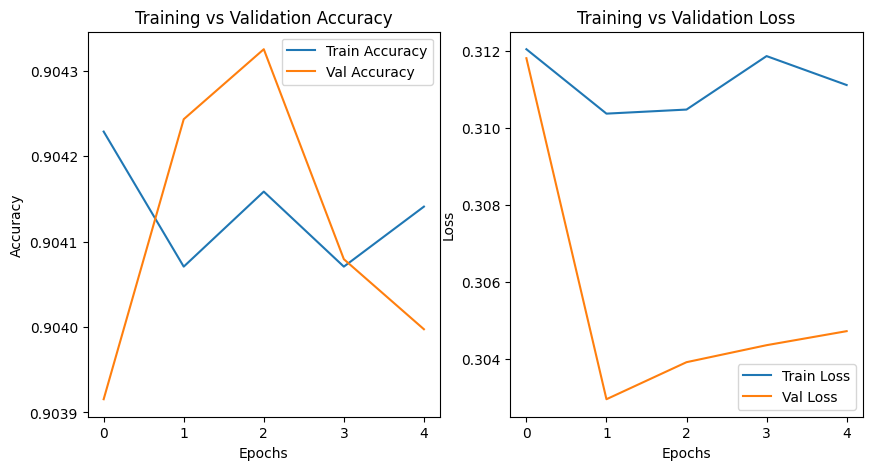

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
# plt.show()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

In [38]:
history.history['loss']
history.history['val_auc']
history.history['precision']

[0.9045518636703491,
 0.9045509696006775,
 0.9046589136123657,
 0.9045225381851196,
 0.9046857357025146]

In [39]:
model.save("best_model_20.h5")
model.save("best_model_20.keras")

In [43]:
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score, f1_score

y_true = np.array(y_test)
y_probs = model.predict(test_ds).ravel()
y_pred = (y_probs > 0.5).astype(int)

print(classification_report(y_true, y_pred, target_names=["Real", "Fake"]))
print("AUC-ROC:", roc_auc_score(y_true, y_probs))
f1 = f1_score(y_true, y_pred.round())
eer = compute_eer(y_true, y_pred.round())
print("F1 Score:", f1)
print("EER : ", eer)

382/382 ━━━━━━━━━━━━━━━━━━━━ 41s 106ms/step
              precision    recall  f1-score   support

        Real       0.75      0.00      0.01      1174
        Fake       0.90      1.00      0.95     11034

    accuracy                           0.90     12208
   macro avg       0.83      0.50      0.48     12208
weighted avg       0.89      0.90      0.86     12208

AUC-ROC: 0.6554772703482097
F1 Score: 0.9495653670711764
EER :  0.498767631347926


In [29]:
# Remove old zip if exists
zip_path = "/kaggle/working/frames_only.zip"
if os.path.exists(zip_path):
    os.remove(zip_path)

In [31]:
import os
import zipfile

# Define paths
source_dirs = ["/kaggle/working/frames/real", "/kaggle/working/frames/fake"]
zip_path = "/kaggle/working/frames_only.zip"

# Remove old zip if exists
if os.path.exists(zip_path):
    os.remove(zip_path)

# Create zip
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for folder in source_dirs:
        for root, dirs, files in os.walk(folder):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, os.path.join("/kaggle/working/frames"))
                zipf.write(file_path, arcname)

# Confirm zip was created
print("ZIP file created at:", zip_path)
print("File size:", os.path.getsize(zip_path), "bytes")

# Show download link
from IPython.display import FileLink
FileLink(zip_path)

ZIP file created at: /kaggle/working/frames_only.zip
File size: 4343770408 bytes


/kaggle/working/frames_only.zip